Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [2]:
data = pd.read_csv('data.csv')

#data.head()

Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [3]:
X = data.drop(['target'], axis = 1)
Y = data['target']

In [120]:
X = X.to_numpy()
Y = data['target'].to_numpy()

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, Y)

In [6]:
model.coef_, round(model.intercept_, 2)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 4.37)

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [9]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - Y)

In [17]:
X.shape, initial_betas.shape

((1000, 10), (10,))

In [24]:
np.dot(X, initial_betas.reshape(-1, 1)).shape

(1000, 1)

In [21]:
np.dot(X, initial_betas.reshape(-1, 1)).ravel().shape

(1000,)

In [22]:
scalar_value.shape

(1000,)

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [ ]:
### Возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [ ]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

### Эта логика поможеn при реализации класса!

In [28]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True):
        """
        :param samples: матрица объектов
        :param targets: вектор (матрица с 1 столбцом) ответов
        :param learning_rate: параметр learning_rate для корректировки нормы градиента
        :param threshold: величина, меньше которой изменение в loss-функции означает 
        :param copy: копировать сэмплы или делать изменения in-place (см. add_constant_feature)
        """
        ### Your code is here
        if copy:
            self.samples = samples.copy()
        else:
            self.samples = samples
            
        self.targets = targets
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.beta = np.ones(self.samples.shape[1])
        self.iteration_loss_dict = {}
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        """
        self.samples['constant'] = 1
        self.beta = np.append(self.beta, 1)    
        
    def calculate_mse_loss(self) -> float:
        """
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        loss = ((np.dot(self.samples, self.beta) - self.targets.values)**2).mean()
        
        return loss
        

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        diff = np.dot(self.samples, self.beta) - self.targets.values
        grad = 2*np.dot(diff, self.samples)/self.samples.shape[0]
        return grad
    
    
    def iteration(self):
        
        self.beta = self.beta - self.learning_rate*self.calculate_gradient()
        return self.beta
        
    def learn(self):
        
        first_step = self.calculate_mse_loss()
        self.calculate_gradient()
        self.iteration()
        second_step = self.calculate_mse_loss()
        
        count = 1
        self.iteration_loss_dict[0] = first_step
        self.iteration_loss_dict[1] = second_step
        
        while abs(second_step - first_step) >= self.threshold:
            first_step = second_step
            self.iteration()
            second_step = self.calculate_mse_loss()
            count += 1
            self.iteration_loss_dict[count] = second_step
            
        ### Your code is here

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [29]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [6]:
print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

[0.88733305 1.90100713 2.88063607 3.87662612 4.89623507 5.89126182
 6.89254811 7.90311947 8.87580109 9.86109585 4.94854733]


In [39]:
list(GD.iteration_loss_dict.values())[-1]

0.010732740689782118

In [19]:
#GD.iteration_loss_dict

Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [22]:
new_GD = GradientDescentMse(samples = X, targets = Y, learning_rate=1)
new_GD.add_constant_feature()
new_GD.learn()

C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Admin\AppData\Local\Temp/ipykernel_9036/1230205192.py:70: RuntimeWarning: invalid value encountered in double_scalars
  while abs(second_step - first_step) >= self.threshold:


В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


In [ ]:
### Your code is here

[0.4356]
[0.4356, 0.7574]
[0.4356, 0.7574, 3.1735]
[0.4356, 0.7574, 3.1735, 5.8495]
[0.4356, 0.7574, 3.1735, 5.8495, 7.0214]
[0.0874]
[0.0874, 0.1418]
[0.0874, 0.1418, 0.4431]
[0.0874, 0.1418, 0.4431, 0.7697]
[0.0874, 0.1418, 0.4431, 0.7697, 3.1855]
[0.0106]
[0.0106, 0.0212]
[0.0106, 0.0212, 0.0881]
[0.0106, 0.0212, 0.0881, 0.1431]
[0.0106, 0.0212, 0.0881, 0.1431, 0.4446]
[0.0011]
[0.0011, 0.0021]
[0.0011, 0.0021, 0.0107]
[0.0011, 0.0021, 0.0107, 0.0213]
[0.0011, 0.0021, 0.0107, 0.0213, 0.0882]


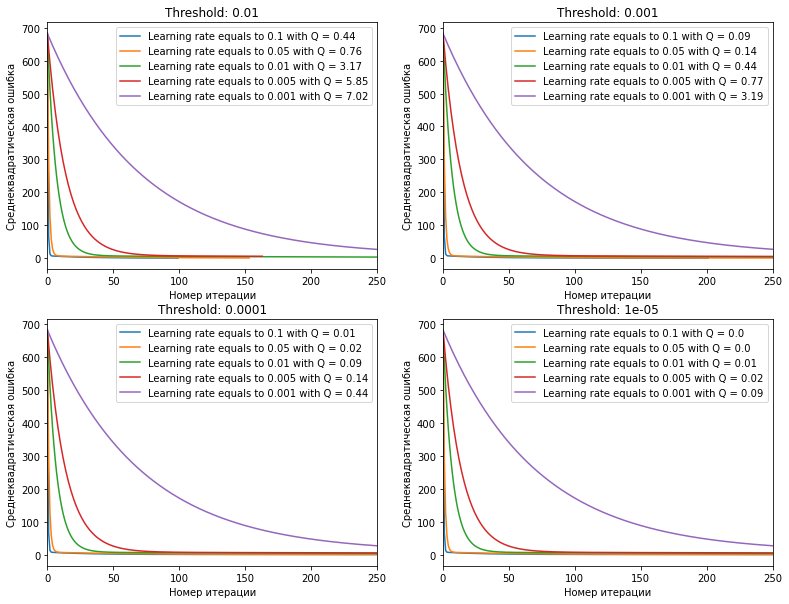

In [45]:
fig = plt.figure()

fig.set_size_inches(13, 10)

rate = [0.1, 0.05, 0.01, 0.005, 0.001]
threshold = [0.01, 0.001, 0.0001, 0.00001]

for i in range(len(threshold)):
    
    thresh = threshold[i]
    ax_ = fig.add_subplot(2, 2, i + 1)
    Q = []
    for j in rate:
        
        GD = GradientDescentMse(samples=X, targets=Y, learning_rate = j, threshold=thresh)
        GD.add_constant_feature()
        GD.learn()
        
        x = GD.iteration_loss_dict.keys()
        y = GD.iteration_loss_dict.values()
        plt.title(f'Threshold: {thresh}')
        
        Q.append(round(list(y)[-1], 4))
        print(Q)
        plt.plot(x, y)
        plt.xlabel('Номер итерации')
        plt.ylabel('Среднеквадратическая ошибка')
        
    plt.legend([f'Learning rate equals to {k} with Q = {round(m, 2)}' for k, m in zip(rate, Q)])
    plt.xlim([0, 250])
plt.show()